In [87]:
import numpy as np
import pandas as pd
from pandas.api.types import (
  is_object_dtype,
  is_numeric_dtype,
)

import sklearn
from sklearn.preprocessing import (
  MinMaxScaler,
  StandardScaler,
  RobustScaler,
  QuantileTransformer,
)
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
  KFold,
  GridSearchCV,
)
from sklearn.metrics import (
  mean_squared_error as mse,
  mean_absolute_error as mae,
)
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

from model import *

sklearn.set_config(transform_output="pandas")
rng = np.random.default_rng(424)

In [2]:
# read dataframe according to the provided dtypes
dtypes = pd.read_csv("data/df_dtypes.csv", index_col="Column")
dtypes_dict = dtypes.to_dict()["Dtype"]
df = (
  pd.read_csv(
    "data/df.csv",
    dtype=dtypes_dict,
    # index_col="HouseId",
  )
  .replace({"Другой": pd.NA})
  .drop(columns="HouseId")
)
targ = "SqMeterCost"

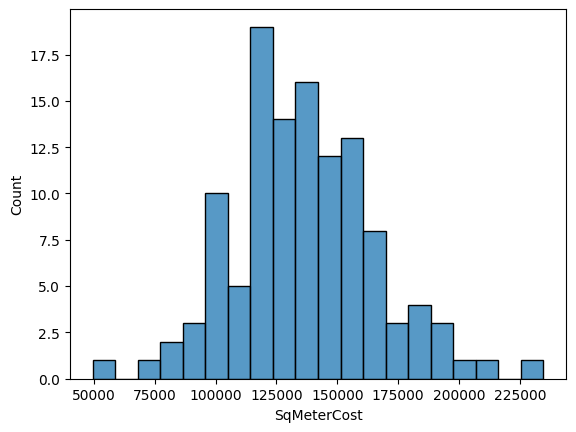

In [3]:
_ = sns.histplot(data=df, x=targ, bins=20)

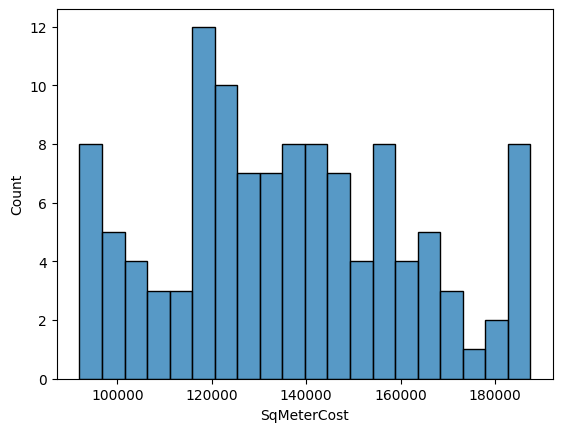

In [4]:
y = df[[targ]]
tail = 0.05
lower = y[targ].quantile(tail)
upper = y[targ].quantile(1 - tail)
y.loc[:, targ] = y.loc[:, targ].apply(
  lambda c: lower if c < lower else upper if c > upper else c
)
_ = sns.histplot(data=y, x=targ, bins=20)

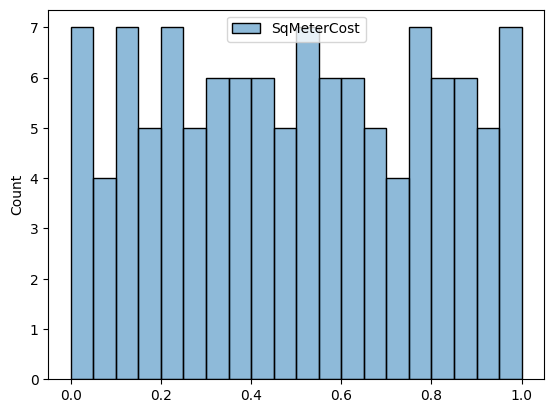

In [5]:
quantiler = QuantileTransformer(n_quantiles=20)
y = quantiler.fit_transform(y)
_ = sns.histplot(y, bins=20)

In [91]:
X = df.drop(columns=targ)
if isinstance(y, pd.DataFrame):
  y = y["SqMeterCost"]

numr_cols = X.dtypes[X.dtypes.map(is_numeric_dtype)].index.to_list()
bool_cols_pred = lambda col: X[col].min() == 0 and X[col].max() == 1
bool_cols = list(filter(bool_cols_pred, numr_cols))
numr_cols = list(set(numr_cols) - set(bool_cols))
catg_cols = X.dtypes[X.dtypes.map(is_object_dtype)].index.to_list()

numr_cols.sort()
bool_cols.sort()
catg_cols.sort()
cols = catg_cols + bool_cols + numr_cols
X = X[cols]

minmax_scaler = ColumnTransformer(
  [("scaler", MinMaxScaler(), numr_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
standard_scaler = ColumnTransformer(
  [("scaler", StandardScaler(), numr_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
robust_scaler = ColumnTransformer(
  [("scaler", RobustScaler(), numr_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

simple_imputer = ColumnTransformer(
  [
    ("mean_imputer", SimpleImputer(strategy="mean"), numr_cols),
    (
      "freq_imputer",
      SimpleImputer(strategy="most_frequent"),
      bool_cols + catg_cols,
    ),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
numr_imputer = ColumnTransformer(
  [("imputer", MyKNNImputer(bool_cols), numr_cols + bool_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
knn_imputer = Pipeline(
  [
    ("numr_imputer", numr_imputer),
    ("catg_imputer", CatgImputer(catg_cols)),
  ]
)

matrl_type_pred = lambda x: x.startswith("Matrl") or x.startswith("Type")
dist_pred = lambda x: x.startswith("Dist")
reach_pred = lambda x: x.startswith("Reach")

short_encoder = ColumnTransformer(
  [
    ("target_encoder", TargetEncoder(), ["HouseCatg", "District"]),
    (
      "binary_encoder",
      BinaryEncoder(),
      list(filter(matrl_type_pred, catg_cols)),
    ),
    (
      "dropped",
      "drop",
      ["CompanyName", "HouseStat"]
      + list(filter(dist_pred, numr_cols))
      + list(filter(reach_pred, bool_cols)),
    ),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

long_encoder = ColumnTransformer(
  [
    ("target_encoder", TargetEncoder(), ["HouseCatg"]),
    (
      "binary_encoder",
      BinaryEncoder(),
      list(filter(matrl_type_pred, catg_cols)),
    ),
    ("dropped", "drop", ["CompanyName", "HouseStat", "District"]),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

reducer = PCA()
reducer__n_components = [10, 20, 30]

param_grid = [
  {
    "scaling": [minmax_scaler, standard_scaler, robust_scaler],
    "imputing": [knn_imputer],
    "encoding": [short_encoder, long_encoder],
    "reduction__n_components": reducer__n_components,
  }
]

In [92]:
lm_pipe = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", "passthrough"),
    ("encoding", "passthrough"),
    ("reduction", reducer),
    ("predictor", LinearRegression()),
  ]
)
lm_grid = GridSearchCV(lm_pipe, param_grid=param_grid)
lm_grid = lm_grid.fit(X, y)

In [96]:
lm_grid.best_score_

-0.6624290732322282

In [93]:
lm_grid.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(),
                                                  ['HouseCatg']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['MatrlFacadeAuxl',
                                                   'MatrlFacadeMain',
                                                   'TypeFacade', 'TypeHouse']),
                                                 ('dropped', 'drop',
                                                  ['CompanyName', 'HouseStat',
                                                   'District'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=10)),
                ('predictor', LinearRegression())])

In [55]:
lasso_pipe = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", knn_imputer),
    ("encoding", "passthrough"),
    ("reduction", reducer),
    ("predictor", Lasso()),
  ]
)
lasso_grid = GridSearchCV(lasso_pipe, param_grid=param_grid)
lasso_grid = lasso_grid.fit(X, y)

In [97]:
lasso_grid.best_score_

-1.6095800780250413

In [58]:
lasso_grid.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'DistTretyaRabochaya',
                                                   'DistVolnoNad',
                                                   'DistVtorayaRechka',
                                                   'ReachBalyaeva',
                                                   'ReachCenter', 'ReachDvfu',
                                                   'ReachLugovaya',
                                                   'ReachOkatovaya',
                                                   'ReachPervayaRechka',
                                                   'ReachTretyaRabochaya',
                                                   'ReachVtorayaRechka'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=10)), ('predictor', Lasso())])

In [59]:
ridge_pipe = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", knn_imputer),
    ("encoding", "passthrough"),
    ("reduction", reducer),
    ("predictor", Ridge()),
  ]
)
ridge_grid = GridSearchCV(ridge_pipe, param_grid=param_grid)
ridge_grid = ridge_grid.fit(X, y)

In [98]:
ridge_grid.best_score_

-0.6453089715934894

In [61]:
ridge_grid.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(),
                                                  ['HouseCatg']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['MatrlFacadeAuxl',
                                                   'MatrlFacadeMain',
                                                   'TypeFacade', 'TypeHouse']),
                                                 ('dropped', 'drop',
                                                  ['CompanyName', 'HouseStat',
                                                   'District'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=30)), ('predictor', Ridge())])

In [68]:
rf_pipe = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", knn_imputer),
    ("encoding", "passthrough"),
    ("reduction", reducer),
    ("predictor", RandomForestRegressor()),
  ]
)
rf_grid = GridSearchCV(rf_pipe, param_grid=param_grid)
rf_grid = rf_grid.fit(X, y)

In [100]:
rf_grid.best_score_

-0.38372857510279135

In [70]:
rf_grid.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(),
                                                  ['HouseCatg']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['MatrlFacadeAuxl',
                                                   'MatrlFacadeMain',
                                                   'TypeFacade', 'TypeHouse']),
                                                 ('dropped', 'drop',
                                                  ['CompanyName', 'HouseStat',
                                                   'District'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=10)),
                ('predictor', RandomForestRegressor())])

In [63]:
def crossval(
  model, n_folds: int, X: pd.DataFrame, y: pd.Series, metrics=None
) -> np.ndarray:

  kfold = KFold(n_folds, shuffle=True)
  if not metrics:
    metrics = [{"name": "mse", "func": mse}, {"name": "mae", "func": mae}]
  cvscores = np.zeros(
    shape=n_folds, dtype=[(metric["name"], "float") for metric in metrics]
  )

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    y_pred = model.predict(X.iloc[test])
    y_pred = quantiler.inverse_transform(pd.DataFrame(y_pred))
    y_true = y.iloc[test]
    y_true = quantiler.inverse_transform(pd.DataFrame(y_true))
    for metric in metrics:
      cvscores[metric["name"]][i] = metric["func"](y_true, y_pred)

  return cvscores

In [94]:
final_pipeline = Pipeline(
  [
    ("scaling", minmax_scaler),
    ("imputing", knn_imputer),
    ("encoding", long_encoder),
    ("reduction", PCA(n_components=10)),
    ("prediction", RandomForestRegressor()),
  ]
)
cv = crossval(final_pipeline, 5, X, y)

/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fit

In [101]:
cv

array([(3.31279066e+08, 11395.38555905), (5.16026595e+08, 15581.43835172),
       (2.45465768e+08, 10267.97719168), (1.80557596e+08,  9680.61016715),
       (2.94446941e+08, 11797.42099099)],
      dtype=[('mse', '<f8'), ('mae', '<f8')])

In [95]:
cv["mae"].mean()

11744.56645211876